# Introduction
![title](images/anime_rec.jpg)
Chewyroll is one of the largest anime streaming platforms on the internet. With their ever growing anime catalog, and increasing number of users, making the right anime recommendations to keep old and new users engaged is important more than ever. 

While the most common method to providing recommendations are through the explicit ratings users provide (ie based on an 'enjoyment' score 1-5; 1-5 stars etc.), collecting and analyzing ratings data is very scarce. Based on the data, it appears most of the time, users do not provide ratings at all, and with the increasing number of anime and users, providing meaningful recommendations solely on this method does not scale. What Chewyroll does have in abundance is 'interaction' or implicit data -- that is data around whether a user has watched something, in the middle of watching, plan to watch, favorited, or even commented on something. 

These data inputs are much more passive from a user's perspective, hence the quantity of implicit data far outweighs the amount of explicit data Chewyroll has. Therefore, in this project Chewyroll has tasked its team of data scientists to take advantage this implicit data and design a more robust recommender system.

# Import Dependencies

In [49]:
import requests as req
import pandas as pd
import numpy as np
import random
import math

import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
import implicit
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns

import ast
import pprint

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

# Data Collection
The cells below will follow a series of steps to collect data about our users and Anime content.

## Kitsu API

Kitsu is a modern anime discovery platform that helps you track the anime you're watching, discover new anime and socialize with other fans.

Within the Kitsu API __https://kitsu.docs.apiary.io/__ -- it contains data pertaining to users and the anime they have watched, rated, liked, commented, and overall have interacted with.

In the next few cells we will aim to pull an initial sample of ~500 users and their interaction data.

In total, there are 1,182,501 users and through the API, we are able to traverse through 20 results at a time. If we traverse through all 1.1M users only 20 at a time, we will need to make 59,125 iterations. 

For MVP purposes, we will pull a sample of 5,000 random users only needing 250 iterations.

To randomly select the 5,000 users knowing we can pull 20 from a page at a time -- we will use the following code to select for those users.

In [2]:
num_users = 1182501
sample_n = 5000
users_per_page = 20
pages_n = int(sample_n / users_per_page)

# Increment the pages
pages_array = np.arange(0,num_users,pages_n)

# Shuffle the array of pages
np.random.shuffle(pages_array)

# Get the first pages_n from pages_array
pages_to_query = pages_array[:pages_n]

print(f'The pages to iterate through: {pages_n} \nThe number of users data to collect: {pages_n*users_per_page}')

The pages to iterate through: 250 
The number of users data to collect: 5000


In [3]:
# Create users dict to collect data
users_dict = {'id':[],
              'name':[],
              'location':[],
              'createdAt':[],
              'lifeSpentOnAnime':[],
              'followersCount':[],
              'followingCount':[],
              'birthday':[],
              'commentsCount':[],
              'favoritesCount':[],
              'likesGivenCount':[],
              'reviewsCount':[],
              'likesReceivedCount':[],
              'postsCount':[],
              'ratingsCount':[],
              'likesReceivedCount':[],
              'proTier':[],
              'relationships':[]}

## Iterate through pages of the Kitsu API to retrieve user data

In [6]:
# Create list of keys to later iterate through 
data_extract = list(users_dict.keys())
data_extract.remove('id')
data_extract.remove('relationships')

# Set up link to iterate through
for page_num in tqdm(pages_to_query):
# for page_num in [20]:
    
    # Set up link to retrieve response from
    kitsu_link = f"https://kitsu.io/api/edge/users?page%5Blimit%5D=20&page%5Boffset%5D={page_num}"

    # Retrieve response
    response = req.get(kitsu_link)
    data = response.json()

    # Iterate through 'data' list in json API response
    for user in data['data']:
        
        # Retrieve desired data points
        attr = user['attributes']
        user_id = user['id']
        rel = user['relationships']
        
        users_dict['id'].append(user_id)
        users_dict['relationships'].append(rel)
        
        # Iterate through users_dict keys for particular data points of interest
        for key in data_extract:
            users_dict[key].append(attr.get(key, np.nan))

In [99]:
# convert users_dict to a dataframe
# animeUsers_df = pd.DataFrame(users_dict)

# Save to csv
# animeUsers_df.to_csv('animeUsers.csv',index=False)

In [4]:
animeUsers_df = pd.read_csv('animeUsers.csv')

In [5]:
# Peek at data
animeUsers_df.head()

,id,name,location,createdAt,lifeSpentOnAnime,followersCount,followingCount,birthday,commentsCount,favoritesCount,likesGivenCount,reviewsCount,likesReceivedCount,postsCount,ratingsCount,proTier,relationships
0,717575,ybicona,Baltimore,2020-04-29T16:36:29.021Z,0,0,0,NaN,0,0,0,0,0,0,0,NaN,{'waifu': {'links': {'self': 'https://kitsu.io...
1,717576,skgsudhirkumar,NaN,2020-04-29T16:36:35.763Z,0,0,0,NaN,0,0,0,0,0,0,0,NaN,{'waifu': {'links': {'self': 'https://kitsu.io...
2,717577,βαγγέλης_μαχαίρας,NaN,2020-04-29T16:37:05.758Z,0,0,0,NaN,0,0,0,0,0,0,12,NaN,{'waifu': {'links': {'self': 'https://kitsu.io...
3,717578,Mame,NaN,2020-04-29T16:37:44.164Z,0,0,0,NaN,0,0,0,0,0,0,5,NaN,{'waifu': {'links': {'self': 'https://kitsu.io...
4,717579,ryan_maulana,NaN,2020-04-29T16:38:07.323Z,0,0,0,NaN,0,0,0,0,0,0,0,NaN,{'waifu': {'links': {'self': 'https://kitsu.io...


From the .head() preview from the cell above, we can tell already that there are some users that are not very active given the 0 values for **lifeSpentOnAnime**, **followersCount**, **followingCount** etc.

In this case, let's sort our dataframe by **favoritesCount**  (as an arbitrary indicator for user activity). From the resulting list, we may take a certain sample active users as a sample to test our implicit recommender model.

In [6]:
animeUsers_df.sort_values('favoritesCount',ascending=False).head(10)

,id,name,location,createdAt,lifeSpentOnAnime,followersCount,followingCount,birthday,commentsCount,favoritesCount,likesGivenCount,reviewsCount,likesReceivedCount,postsCount,ratingsCount,proTier,relationships
979,85539,maria12021,Norway,2015-04-06T00:55:29.333Z,74217,4,2,2001-04-18,0,209,0,0,0,0,605,NaN,{'waifu': {'links': {'self': 'https://kitsu.io...
2754,143115,Liv_Martin_Strong,UK,2017-01-16T01:03:19.919Z,0,36,28,1991-08-14,44,139,26,27,30,33,280,NaN,{'waifu': {'links': {'self': 'https://kitsu.io...
3747,121938,70a573r,The Government,2016-03-20T23:46:32.451Z,20854,6,2,2001-09-11,2,86,4,1,7,3,5,NaN,{'waifu': {'links': {'self': 'https://kitsu.io...
3971,70211,LadyGira,Pirate Ship,2014-12-09T04:44:12.856Z,451853,5,10,NaN,0,82,10,0,1,0,1040,NaN,{'waifu': {'links': {'self': 'https://kitsu.io...
2523,86869,nick_gooeygrass,NaN,2015-04-15T23:18:46.962Z,73828,1,1,NaN,0,55,0,0,0,0,96,NaN,{'waifu': {'links': {'self': 'https://kitsu.io...
2149,78730,Iago,South,2015-02-07T13:48:55.698Z,137029,69,61,NaN,6,51,986,0,-9,3,655,NaN,{'waifu': {'links': {'self': 'https://kitsu.io...
2487,561112,kevintombs20,NaN,2019-08-13T18:19:22.094Z,0,0,0,NaN,0,46,0,0,0,0,71,NaN,{'waifu': {'links': {'self': 'https://kitsu.io...
4833,100364,Wolfwood93,Colorado,2015-08-08T17:34:30.626Z,96306,15,6,1993-09-13,2,44,14,0,-2,-1,178,NaN,{'waifu': {'links': {'self': 'https://kitsu.io...
119,278590,BarretKun,"São Bernardo do Campo, SP, Brazil",2018-05-29T16:05:06.030Z,0,1,1,1999-06-24,0,41,0,0,0,0,172,NaN,{'waifu': {'links': {'self': 'https://kitsu.io...
1970,582074,Legorion,"Latvia,Riga",2019-09-22T15:42:08.578Z,0,4,5,1986-09-22,1,39,3,0,0,0,37,NaN,{'waifu': {'links': {'self': 'https://kitsu.io...


In order to get a better idea of the type interactions most done, we will plot a bar graph of the counts per interaction type.

Interaction types include:
- Comments
- Favorites
- Likes Given
- Reviews Given
- Posts Given
- Ratings Given

commentsCount        2178
favoritesCount       4178
likesGivenCount      5689
reviewsCount          100
postsCount            920
ratingsCount       135568
dtype: int64



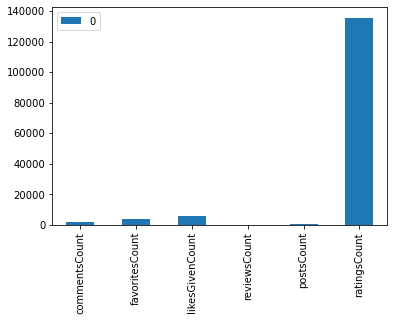

In [7]:
# Examine distribution of interaction types among users
interaction_list = ['commentsCount',
                    'favoritesCount', 
                    'likesGivenCount', 
                    'reviewsCount',
                    'postsCount', 
                    'ratingsCount']

print(animeUsers_df[interaction_list].sum())
print()

pd.DataFrame(animeUsers_df[interaction_list].sum()).plot(kind='bar');

It appears providing ratings is the most common type of interaction users have with anime. However, since this project is aimed to look beyond a recommendation model based on the explicit ratings users provide for anime, we will dive a bit deeper into different interaction types. This will require us to be more creative with what API endpoints we wish to call, and what data points to collect from those resulting responses.

## Segment Users
We will use a combination of lifeSpentonAnime, favoritesCount, and ratingsCount as the primary indicators for levels of engagement with anime. We will cut this feature into 3 bins categorizing a users level of anime engagement. The 3 labels will be "low", "medium", and "high." We will use the medium - high category users for downstream analysis.

When combining lifeSpentonAnime, favoritesCount, and ratingsCount, we will add a higher weightage to ratingsCount and favoritesCount since this is interaction is more involved than time spent on anime.

In [73]:
# Let's remove users where lifeSpentOnAnime and ratingsCount is both 0
animeUsers_df = animeUsers_df[(animeUsers_df['lifeSpentOnAnime'] != 0)
                              & (animeUsers_df['ratingsCount'] != 0)]

# Reset index
animeUsers_df.reset_index(drop=True,inplace=True)

# Create interaction score metric to help bin the users
# We will also retrieve the log since there is a severe skew of users that spent time on and rate anime
animeUsers_df['interaction_score'] = np.log(
    animeUsers_df['lifeSpentOnAnime'] +
    (animeUsers_df['ratingsCount'] * 1.25) +
    (animeUsers_df['favoritesCount'] * 1.5))

# Preview data
animeUsers_df[['lifeSpentOnAnime', 'ratingsCount',
               'favoritesCount', 'interaction_score']].head(5)

,lifeSpentOnAnime,ratingsCount,favoritesCount,interaction_score
0,240586,607,0,12.393982
1,3125,6,0,8.049587
2,1788,6,3,7.495542
3,3520,9,0,8.169407
4,66950,6,0,11.111813


In [66]:
# Create column called interaction_label to categorize interaction_score into low, medium, or high
animeUsers_df['interaction_label'] = pd.cut(animeUsers_df.interaction_score, 3, labels=['Low', 'Medium', 'High'])

# Preview data
animeUsers_df[['lifeSpentOnAnime','ratingsCount','favoritesCount','interaction_score','interaction_label']].head(5)

,lifeSpentOnAnime,ratingsCount,interaction_score,interaction_label
20,240586,607,12.393982,High
21,3125,6,8.049587,Medium
22,1788,6,7.495542,Medium
23,3520,9,8.169407,Medium
26,66950,6,11.111813,High


In [67]:
# Preview the distribution of interaction_labels

animeUsers_df['interaction_label'].value_counts()

Medium    210
High      185
Low        35
Name: interaction_label, dtype: int64

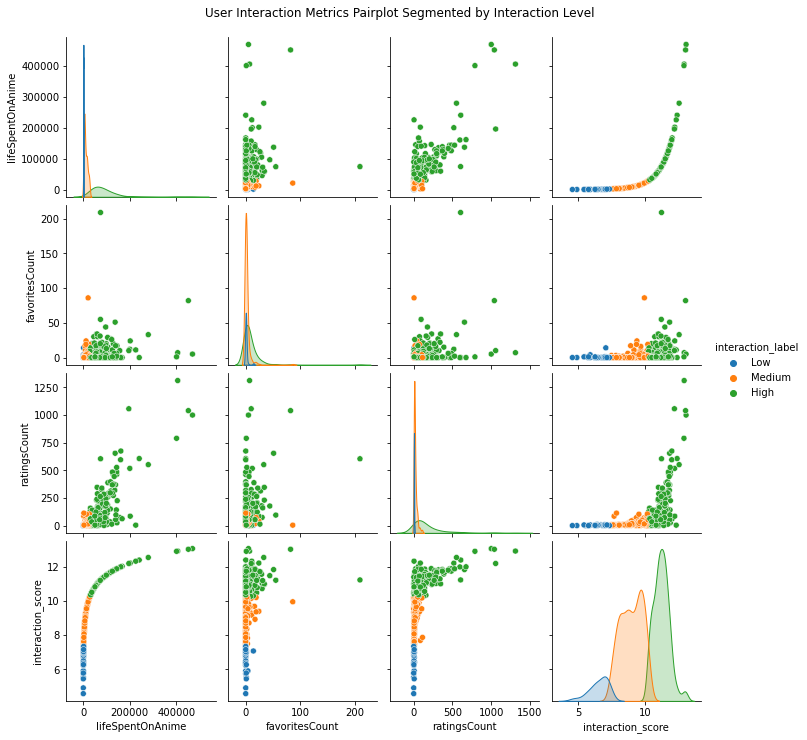

In [101]:
# Lets select a few measure to help us visualize the differentiation between the segmented users based on interaction score
interaction_list_update = [
    'lifeSpentOnAnime', 'favoritesCount', 'ratingsCount', 'interaction_score',
    'interaction_label'
]

# Plot pairplot
g = sns.pairplot(animeUsers_df[interaction_list_update],
                 hue='interaction_label')
g.fig.suptitle(
    'User Interaction Metrics Pairplot Segmented by Interaction Level',

# Format and savefig
plt.savefig('User_Interaction_Metrics_Pairplot.jpg',
            bbox_inches='tight',
            dpi=300)

The visual above showcases how our segmenting efforts distribute and correlated with the user metrics of interest: lifeSpentOnAnime, favoritesCount, and ratingsCount. Based on this pairplot visual, it is worth noting that lifeSpentOnAnime and ratingsCount appear to have the most linear (although not perfect) relationship amongst these features. Perhaps the more a user spends watching anime, they are more inclined to provide a rating as well as opposed to favoriting an anime. Moreover, lifeSpentonAnime appears to have an extreme right skew -- by taking the log and adding a weightage to favorites and ratings counts, high interaction type users appears to have a high spread despite having lower lifeSpentOnAnime metric (as seen in the top left figure). This indicates that perhaps users are still rating and favoriting anime despite not having their time recorded watching anime. Maybe these users are watching on other streaming platforms, but providing their ratings and favorites on the Tastyroll platform.

In the cell below, let's create a helper function we'll more commonly use to get the JSON response of an API call.

In [70]:
def get_kitsu_response(link):
    """
    Returns a pretty printed response from JSON object
    
    Parameters
    ----------
    link : str
        The URL to query from Kitsu API

    Returns
    -------
    pretty printed view of json response
    
    """
    kitsu_response = req.get(link)
    kitsu_data = kitsu_response.json()
    return kitsu_data

In [74]:
# Peek at few examples of relationships column
jt = ast.literal_eval(animeUsers_df['relationships'][0])
jt2 = ast.literal_eval(animeUsers_df['relationships'][4])

In [75]:
# Check kitsu response test # 1
get_kitsu_response( jt['favorites']['links']['related'] )

{'data': [],
 'meta': {'count': 0},
 'links': {'first': 'https://kitsu.io/api/edge/users/131073/favorites?page%5Blimit%5D=10&page%5Boffset%5D=0',
  'last': 'https://kitsu.io/api/edge/users/131073/favorites?page%5Blimit%5D=10&page%5Boffset%5D=0'}}

In [76]:
# Check kitsu response test # 2
get_kitsu_response( jt2['favorites']['links']['related'] )

{'data': [],
 'meta': {'count': 0},
 'links': {'first': 'https://kitsu.io/api/edge/users/131079/favorites?page%5Blimit%5D=10&page%5Boffset%5D=0',
  'last': 'https://kitsu.io/api/edge/users/131079/favorites?page%5Blimit%5D=10&page%5Boffset%5D=0'}}

Through sifting through the [Kitsu API Docs](https://kitsu.docs.apiary.io/), a couple of feasible / easy-to-retrieve interaction data types include a users
- Favorites
- Library Entries

**Favorites** are a bit more self-explanatory, where if a user simply enjoys / enjoyed or wants to actively save an anime for their record, the common interaction is to *favorite* that anime.

**Library Entries** is an interesting API endpoint to look at as it gives us data on the viewing history, and to what extent a user has watched an anime. Within the JSON response, for example we are able to retrieve data on the following
- Start watch time
- Finish end time
- Time spent watching an anime
- Watch status of an anime
     - Completed
     - Current (In progress)
     - Dropped
     - On hold
     - Planned

Below we will create functions to uniquely extract the data points of interest from the *favorites* and *library entries* endpoints so that we can format the results into a pandas dataframe for downstream analysis.

## Retrieve Favorite Anime per User

In [117]:
def get_user_favorites(user_id):
    """
    Returns a list of a user's favorite anime
    
    Parameters
    ----------
    user_id : int
        user_id
    Returns
    -------
    Dictionary of the user's favorited anime
    
    """
    print(f'Retrieving favorites data for user {user_id}')
    kitsu_link = f'https://kitsu.io/api/edge/favorites/?filter[userId]={user_id}&[itemType]=Media'
    kitsu_response = req.get(kitsu_link)
    kitsu_data = kitsu_response.json()

    # Store favorites dictionary
    fav_dict = {
        'user_id': None,
        'anime_id': [],
        'canonicalTitle': [],
        'synopsis': [],
        'description': []
    }

    # Check for number of favorites -- if more than 10; paginate through all favorites else retrieve favorites on page
    favorites_count = kitsu_data['meta']['count']

    pages = math.floor((favorites_count / 10) + 1)
    page_nums = []
    count = 0
    # Create list of pages to paginate through
    for num in range(pages):
        page_nums.append(num * 10)

    # Retrieve data from each page
    for page in page_nums:
        link = f'https://kitsu.io/api/edge/favorites?filter%5BuserId%5D={user_id}&page%5Blimit%5D=10&page%5Boffset%5D={page}'
        fav_page = get_kitsu_response(link)
        for fav in fav_page['data']:

            # Get link to retrieve anime data
            item = fav['relationships']['item']['links']['related']
            anime_response = get_kitsu_response(item)

            # Check that the user's marked favorite is an anime
            if anime_response['data']['type'] == 'anime':

                title = anime_response['data']['attributes'].get(
                    'canonicalTitle', np.nan)
                anime_id = anime_response['data'].get('id', np.nan)
                synopsis = anime_response['data']['attributes'].get(
                    'synopsis', np.nan)
                desc = anime_response['data']['attributes'].get(
                    'description', np.nan)

                fav_dict['anime_id'].append(anime_id)
                fav_dict['canonicalTitle'].append(title)
                fav_dict['synopsis'].append(synopsis)
                fav_dict['description'].append(desc)
                count += 1

            # If the marked favorite is not an anime --> skip
            else:
                continue

    # Create a list of the users_id to map every item to the user
    user_id_list = [user_id] * count
    fav_dict['user_id'] = user_id_list

    return fav_dict

## Retrieve Library Entries per User

In [176]:
def get_user_library_entries(user_id):
    """
    Returns a list of a user's library entries. 
    The output of this function will detail anime the user has watched, planned to watch, or stopped watching.
    
    Parameters
    ----------
    user_id : int
        user_id
    Returns
    -------
    Dictionary of the anime a user has interacted with.
    
    """
    print(f'Retrieving library entry data for user {user_id}')
    kitsu_link = f'https://kitsu.io/api/edge/library-entries/?filter[userId]={user_id}&[kind]=anime'
    kitsu_response = req.get(kitsu_link)
    kitsu_data = kitsu_response.json()

    # Store favorites dictionary
    lib_entry_dict = {
        'user_id': None,
        'anime_id': [],
        'status': [],
        'progress': [],
        'progressedAt': [],
        'startedAt': [],
        'finishedAt': [],
        'canonicalTitle': [],
        'synopsis': [],
        'description': []
    }

    # Check for number of favorites -- if more than 10; paginate through all favorites else retrieve favorites on page
    entries_count = kitsu_data['meta']['count']

    pages = math.floor((entries_count / 10) + 1)
    page_nums = []
    count = 0
    # Create list of pages to paginate through
    for num in range(pages):
        page_nums.append(num * 10)

    # Retrieve data from each page
    for page in page_nums:
        link = f'https://kitsu.io/api/edge/library-entries?filter%5BuserId%5D={user_id}&page%5Blimit%5D=10&page%5Boffset%5D={page}'
        le_page = get_kitsu_response(link)
        for le in le_page['data']:

            # Retrieve watch status data
            attr = le['attributes']
            status = attr['status']
            progress = attr['progress']
            progressedAt = attr['progressedAt']
            startedAt = attr['startedAt']
            finishedAt = attr['finishedAt']

            # Get link to retrieve anime data
            item = le['relationships']['anime']['links']['related']
            anime_response = get_kitsu_response(item)
            try:
                title = anime_response['data']['attributes'].get(
                    'canonicalTitle', np.nan)
                anime_id = anime_response['data'].get('id', np.nan)
                synopsis = anime_response['data']['attributes'].get(
                    'synopsis', np.nan)
                desc = anime_response['data']['attributes'].get(
                    'description', np.nan)

                lib_entry_dict['status'].append(status)
                lib_entry_dict['progress'].append(progress)
                lib_entry_dict['progressedAt'].append(progressedAt)
                lib_entry_dict['startedAt'].append(progressedAt)
                lib_entry_dict['finishedAt'].append(finishedAt)
                lib_entry_dict['anime_id'].append(anime_id)
                lib_entry_dict['canonicalTitle'].append(title)
                lib_entry_dict['synopsis'].append(synopsis)
                lib_entry_dict['description'].append(desc)
                count += 1
            except TypeError:
                continue

    # Create a list of the users_id to map every item to the user
    user_id_list = [user_id] * count
    lib_entry_dict['user_id'] = user_id_list

    return lib_entry_dict

# Run retrieval functions for a sample of users
This sample of users were selected based on those with the highest activity (aka high favorites count). We will keep the number of users to a minimum to limit the amount of API calls, to prevent our requests from being timed out.

In [119]:
animeUsers_df.head()

,id,name,location,createdAt,lifeSpentOnAnime,followersCount,followingCount,birthday,commentsCount,favoritesCount,likesGivenCount,reviewsCount,likesReceivedCount,postsCount,ratingsCount,proTier,relationships,interaction_score,interaction_label
0,131073,Polarization,NaN,2016-07-05T17:01:47.553Z,240586,0,0,NaN,0,0,0,0,0,0,607,NaN,{'waifu': {'links': {'self': 'https://kitsu.io...,12.393982,High
1,131074,khiem_tang,NaN,2016-07-05T17:03:08.744Z,3125,0,0,NaN,0,0,0,0,0,0,6,NaN,{'waifu': {'links': {'self': 'https://kitsu.io...,8.049587,Medium
2,131075,bee_perez,NaN,2016-07-05T17:12:21.352Z,1788,0,0,NaN,0,3,0,0,0,0,6,NaN,{'waifu': {'links': {'self': 'https://kitsu.io...,7.495542,Medium
3,131076,TaliBear,NaN,2016-07-05T17:21:46.257Z,3520,0,0,NaN,0,0,0,0,0,0,9,NaN,{'waifu': {'links': {'self': 'https://kitsu.io...,8.169407,Medium
4,131079,mmokazui,NaN,2016-07-05T17:46:52.764Z,66950,0,0,NaN,0,0,0,0,0,0,6,NaN,{'waifu': {'links': {'self': 'https://kitsu.io...,11.111813,High


In [173]:
# Select random list of users to retrive their interaction data
# user_list_rand = animeUsers_df[animeUsers_df['interaction_label'].isin(['Medium','High'])]['id'].sample(10).tolist()

# High activity users we want to examine 
select_users = [85539, 143115, 121938, 70211, 86869]

# Combin
# user_sample_list = list(set(user_list_rand + select_users))

user_sample_list = select_users

In [174]:
# Retrieve sample of favorites data per user
users_favs_df = pd.DataFrame()

# Per user get their favorites anime and format into a pandas dataframe
for user in user_sample_list:
    df = pd.DataFrame(get_user_favorites(user))
    users_favs_df = users_favs_df.append(df)

Retrieving favorites data for user 85539
Retrieving favorites data for user 143115
Retrieving favorites data for user 121938
Retrieving favorites data for user 70211
Retrieving favorites data for user 86869


In [175]:
# Save anime favorites data per user
users_favs_df.to_csv('animeFavorites_data.csv',index=False)

# users_favs_df = pd.read_csv('animeFavorites_data.csv')

In [177]:
# Retrieve sample of library entries data per user
users_le_df = pd.DataFrame()

# Per user get their library entries per anime and format into a pandas dataframe
for user in user_sample_list:
    df = pd.DataFrame(get_user_library_entries(user))
    users_le_df = users_le_df.append(df)

Retrieving library entry data for user 85539
Retrieving library entry data for user 143115
Retrieving library entry data for user 121938
Retrieving library entry data for user 70211
Retrieving library entry data for user 86869


In [178]:
# Save anime library entries data per user
users_le_df.to_csv('animeWatchStatus_data.csv',index=False)

# users_le_df = pd.read_csv('animeWatchStatus_data.csv')

In [179]:
# Peek at users library entries data
users_le_df.head()

,user_id,anime_id,status,progress,progressedAt,startedAt,finishedAt,canonicalTitle,synopsis,description
0,85539,176,completed,1,2016-04-05T21:53:57.987Z,2016-04-05T21:53:57.987Z,2016-04-05T00:00:00.000Z,Spirited Away,"Stubborn, spoiled, and naïve, 10-year-old Chih...","Stubborn, spoiled, and naïve, 10-year-old Chih..."
1,85539,6711,completed,1,2015-11-07T21:02:56.128Z,2015-11-07T21:02:56.128Z,2015-11-07T00:00:00.000Z,Wolf Children,"Hana, a hard-working college student, falls in...","Hana, a hard-working college student, falls in..."
2,85539,142,completed,1,2016-04-05T21:54:13.337Z,2016-04-05T21:54:13.337Z,2016-04-05T00:00:00.000Z,Princess Mononoke,When an Emishi village is attacked by a fierce...,When an Emishi village is attacked by a fierce...
3,85539,8403,completed,22,2015-04-06T00:57:29.294Z,2015-04-06T00:57:29.294Z,2015-04-06T00:00:00.000Z,Shigatsu wa Kimi no Uso,Music accompanies the path of the human metron...,Music accompanies the path of the human metron...
4,85539,8147,completed,24,2017-04-14T04:09:37.510Z,2017-04-14T04:09:37.510Z,2017-04-14T00:00:00.000Z,Kiseijuu: Sei no Kakuritsu,"All of a sudden, they arrived: parasitic alien...","All of a sudden, they arrived: parasitic alien..."


# Data Processing to set up Recommender Model
In this section we are going to process the data from user favorites and library entries so we can create the user and anime vectors to feed into our implicit alternating least squares (ALS) recommender model. We will follow the steps below.
1. Combine the data from user favorites and user library entries.
2. Afterwards, we create an arbitrary "eventStrength" based on the status column to indicate the "level of interaction" a user has with a particular anime.
3. Create sparse ratings matrix and fit to implicit ALS model.

In [180]:
# Create status column to align and later combine with users_le_df
# 'favorite' will be used as an event type
users_favs_df['status'] = 'favorite'

In [181]:
# Peek at data
users_favs_df.head()

,user_id,anime_id,canonicalTitle,synopsis,description,status
0,85539,8403,Shigatsu wa Kimi no Uso,Music accompanies the path of the human metron...,Music accompanies the path of the human metron...,favorite
1,85539,8147,Kiseijuu: Sei no Kakuritsu,"All of a sudden, they arrived: parasitic alien...","All of a sudden, they arrived: parasitic alien...",favorite
2,85539,6836,Tsuritama,Yuki Sanada is a socially awkward young man wh...,Yuki Sanada is a socially awkward young man wh...,favorite
3,85539,8333,Gugure! Kokkuri-san,"Kohina Ichimatsu, the self-proclaimed doll, ca...","Kohina Ichimatsu, the self-proclaimed doll, ca...",favorite
4,85539,5981,Ano Hi Mita Hana no Namae wo Bokutachi wa Mada...,Jinta Yadomi is peacefully living as a recluse...,Jinta Yadomi is peacefully living as a recluse...,favorite


In [182]:
# Compare shapes of favs and library entries dataframes
print(users_favs_df.shape)
print(users_le_df.shape)

(306, 6)
(4004, 10)


Between the user favorites and user library entries dataframe -- there is a difference in the number of columns. In this case we we will need to align and select our columns for further analysis.  

In [183]:
# Peek at select columns to keep in combined dataframe
list(users_favs_df.columns)

['user_id', 'anime_id', 'canonicalTitle', 'synopsis', 'description', 'status']

In [184]:
# Set columns between both dataframes to be equal for combining
col_list = list(users_favs_df.columns)

users_le_df_append = users_le_df.copy()

# Filter library entries df to match columns of favorites df
users_le_df_append = users_le_df_append[col_list]

# Combine library entries and favorites df
user_interaction_df = users_le_df_append.append(users_favs_df, ignore_index=True)

# Peek at data
user_interaction_df.head()

,user_id,anime_id,canonicalTitle,synopsis,description,status
0,85539,176,Spirited Away,"Stubborn, spoiled, and naïve, 10-year-old Chih...","Stubborn, spoiled, and naïve, 10-year-old Chih...",completed
1,85539,6711,Wolf Children,"Hana, a hard-working college student, falls in...","Hana, a hard-working college student, falls in...",completed
2,85539,142,Princess Mononoke,When an Emishi village is attacked by a fierce...,When an Emishi village is attacked by a fierce...,completed
3,85539,8403,Shigatsu wa Kimi no Uso,Music accompanies the path of the human metron...,Music accompanies the path of the human metron...,completed
4,85539,8147,Kiseijuu: Sei no Kakuritsu,"All of a sudden, they arrived: parasitic alien...","All of a sudden, they arrived: parasitic alien...",completed


Based on these interaction or event types we've extracted, we will set up dictionary to associate a weight or strength to say that a user's action to *favorite* or *complete* is much stronger than *dropping* or putting it *on hold*. 

In [185]:
# Set up event strength dict to assign arbitrary strength score towards interaction types
event_strength = {
    'completed':6.0,
    'favorite':5.0,
    'current':4.0,
    'planned':3.0,
    'on_hold':2.0,
    'dropped':1.0
}

In [186]:
# Map event strength scores according to status set in user_interaction_df
user_interaction_df['eventStrength'] = user_interaction_df['status'].apply(lambda x: event_strength[x])

In [187]:
# Peek at data
user_interaction_df.head()

,user_id,anime_id,canonicalTitle,synopsis,description,status,eventStrength
0,85539,176,Spirited Away,"Stubborn, spoiled, and naïve, 10-year-old Chih...","Stubborn, spoiled, and naïve, 10-year-old Chih...",completed,6.0
1,85539,6711,Wolf Children,"Hana, a hard-working college student, falls in...","Hana, a hard-working college student, falls in...",completed,6.0
2,85539,142,Princess Mononoke,When an Emishi village is attacked by a fierce...,When an Emishi village is attacked by a fierce...,completed,6.0
3,85539,8403,Shigatsu wa Kimi no Uso,Music accompanies the path of the human metron...,Music accompanies the path of the human metron...,completed,6.0
4,85539,8147,Kiseijuu: Sei no Kakuritsu,"All of a sudden, they arrived: parasitic alien...","All of a sudden, they arrived: parasitic alien...",completed,6.0


In [188]:
# Group event strength per user and anime
grouped_df = user_interaction_df.groupby(['user_id', 'anime_id', 'canonicalTitle'])['eventStrength'].sum().reset_index()
grouped_df.sample(10)

,user_id,anime_id,canonicalTitle,eventStrength
3324,121938,13463,Shiyan Pin Jiating,4.0
3963,143115,7978,Sakura Trick,4.0
3744,143115,13600,Darling in the FranXX,4.0
1636,70211,7234,Kono Sekai no Katasumi ni,3.0
1975,85539,10350,Jitsu wa Watashi wa,3.0
2234,85539,13225,Juuni Taisen,6.0
1419,70211,5324,Durarara!! Specials,6.0
3269,121938,11940,Kuzu no Honkai,6.0
218,70211,11593,Ange Vierge,3.0
379,70211,12667,Oushitsu Kyoushi Heine,3.0


With an aggregated eventStrength -- we aim to use this metric to represent a "confidence" measure in how strong the level of interaction was for a user and anime.

# Fit Alternating Least Squares Model
We will focus on using the Alternating Least Square algorithm to handle our implicit feedback.  It is one of the most common, yet effective methods when creating a recommender system based on implicit data.

In our case, we will use the python implicit library found here: https://implicit.readthedocs.io/en/latest/als.html

In [189]:
grouped_df['canonicalTitle'] = grouped_df['canonicalTitle'].astype("category")
grouped_df['user_id'] = grouped_df['user_id'].astype("category")
grouped_df['anime_id'] = grouped_df['anime_id'].astype("category")
grouped_df['person_id'] = grouped_df['user_id'].cat.codes
grouped_df['content_id'] = grouped_df['anime_id'].cat.codes

# Create sparse ratings matrix of users and anime
sparse_content_mat = sparse.csr_matrix((grouped_df['eventStrength'].astype(float), (grouped_df['content_id'], grouped_df['person_id'])))
sparse_person_mat = sparse.csr_matrix((grouped_df['eventStrength'].astype(float), (grouped_df['person_id'], grouped_df['content_id'])))

In [190]:
# Create lookup table that we tracks and reference id to title
anime_lookup = grouped_df[['content_id', 'canonicalTitle']].drop_duplicates()

In [191]:
# Peek at lookup table
anime_lookup.head()

,content_id,canonicalTitle
0,0,Cowboy Bebop
1,1,Monster
2,2,Fullmetal Alchemist
3,4,Ore Monogatari!!
4,6,Kyoukai no Rinne (TV)


In [192]:
# Check out matrix object
sparse_content_mat

<2578x5 sparse matrix of type '<class 'numpy.float64'>'
	with 4004 stored elements in Compressed Sparse Row format>

In [193]:
# Check out matrix object
sparse_person_mat

<5x2578 sparse matrix of type '<class 'numpy.float64'>'
	with 4004 stored elements in Compressed Sparse Row format>

In [194]:
# Create ALS model and fit to sparse ratings matrix
model = implicit.als.AlternatingLeastSquares(factors=20, regularization=0.1, iterations=50)

alpha = 15
data = (sparse_content_mat * alpha).astype('double')
model.fit(data)

In [195]:
# Calculate the matrix sparsity 
matrix_size = sparse_content_mat.shape[0]*sparse_content_mat.shape[1] # Number of possible interactions in the matrix
num_interact = len(sparse_content_mat.nonzero()[0]) # Number of items interacted with
sparsity = 100*(1 - (num_interact/matrix_size))
sparsity

68.93716058960435

According to the computed value above -- 75.6% of the interaction matrix is sparse. 

In [196]:
# Peek at random 10 rows
grouped_df.sample(10)

,user_id,anime_id,canonicalTitle,eventStrength,person_id,content_id
2658,85539,4782,Hellsing I: Digest for Freaks,3.0,1,1737
2202,85539,12536,To Be Hero,6.0,1,473
834,70211,403,Shoujo Kakumei Utena,6.0,0,1096
1345,70211,447,Kino no Tabi: The Beautiful World,3.0,0,1697
2610,85539,42909,Enen no Shouboutai: Ni no Shou,3.0,1,1552
601,70211,1415,Code Geass: Lelouch of the Rebellion,6.0,0,797
2724,85539,5985,Hyouge Mono,3.0,1,1888
902,70211,41223,Kidou Senshi Gundam Narrative,3.0,0,1179
1813,70211,8268,Black Butler: Book of Circus,11.0,0,2392
1664,70211,7370,Nagi no Asukara,11.0,0,2172


# Set up initial recommendation model using interaction data

In [197]:
# Importing useful recommendation functions from .py file
# Credit to https://github.com/jmsteinw
from implicit_rec_functions import *

In [198]:
product_train, product_test, product_users_altered = make_train(sparse_person_mat, pct_test = 0.2)

In [199]:
alpha = 15
user_vecs, item_vecs = implicit.alternating_least_squares((product_train*alpha).astype('double'), 
                                                          factors=20,
                                                          regularization = 0.1, 
                                                         iterations = 50)

Using AUC score as a metric for modeling: https://stats.stackexchange.com/questions/68893/area-under-curve-of-roc-vs-overall-accuracy

With the 'make_train' function we imported -- we set aside 20% of our data for testing and evaluating our recommender system. We will need to see if the order of anime recommendations end up being anime the user eventually interacted with (favorited, completed, in progress etc).

We will also use a function imported called 'calc_mean_auc' which will calculate the AUC for the most popular anime to compare the anime our user actually interacted with. 

# Initial Model Evaluation

In [200]:
# Importing calc_mean_auc to compare the AUC value of our recommender system versus recommender the most popular
calc_mean_auc(product_train, product_users_altered, 
              [sparse.csr_matrix(user_vecs), sparse.csr_matrix(item_vecs.T)], product_test)

(0.537, 0.778)

We see from the results above that our recommender system had a mean AUC of 0.62 versus the popular anime benchmark of 0.616. While not incredibly impressive, our recommender system is performing slightly better than if we were to recommend the most popular anime.

In [203]:
# Get unique users
users = list(np.sort(grouped_df.person_id.unique()))

# Get unique anime interacted with
anime = list(grouped_df.content_id.unique())

# Create numpy array of users and anime
users_arr = np.array(users)
anime_arr = np.array(anime)

In [204]:
def get_anime_interacted(person_id, mf_train, users_list, anime_list, anime_lookup):
    """
    Returns a dataframe showcasing the anime a user has already interacted with in the training set.
    
    Parameters
    ----------
    user_id : int
    mf_train: sparse_matrix
    users_list: numpy array of users
    anime_list: numpy array of anime
    anime_lookup: lookup of id and anime
    Returns
    -------
    Pandas dataframe
    
    """
    # Returns the index row of our user id
    user_ind = np.where(users_list == person_id)[0][0]
    
    # Get column indices of interacted anime
    interacted_ind = mf_train[user_ind,:].nonzero()[1]
    
    anime_codes = anime_list[interacted_ind]
    return anime_lookup.loc[anime_lookup.content_id.isin(anime_codes)]

In [218]:
# Check for anime interacted with for a give user
get_anime_interacted(0, product_train, users_arr, anime_arr, anime_lookup).head(10)

,content_id,canonicalTitle
1,1,Monster
2,2,Fullmetal Alchemist
4,6,Kyoukai no Rinne (TV)
8,11,Detective Conan: The Sunflowers of Inferno
10,14,Subete ga F ni Naru: The Perfect Insider
11,15,Punch Line
14,19,Kyoukai no Kanata Movie 2: I'll Be Here - Mira...
15,20,Garo: Guren no Tsuki
16,21,Shouwa Genroku Rakugo Shinjuu
19,24,Hetalia: The World Twinkle


We will create a function below to take in training set we saved along with our user and anime vectors to recommend anime for a given user.

In [206]:
def rec_anime(user_id, mf_train, user_vecs, item_vecs, user_list, anime_list, item_lookup, num_items = 10):
    """
    Returns a list of a user's favorite anime

    Parameters
    ----------
    user_id : The user_id that we aim to provide recommendations for
    mf_train: Training matrix
    user_vecs: User vectors from fitted matrix factorization
    anime_vecs: Anime vectors from fitted matrix factorization
    user_list: Array of user ID numbers
    anime_list: Array of anime ID numbers
    item_lookup: Pandas dataframe of anime ID and canonical title

    Returns
    -------
    Top n recommendations based on the user/anime vectors for anime a user has not interacted with
    """
    
    # Get index row of user_id
    cust_ind = np.where(user_list == user_id)[0][0]
    pref_vec = mf_train[cust_ind,:].toarray()
    # Add 1 to everything, so that anime not interacted yet become equal to 1
    pref_vec = pref_vec.reshape(-1) + 1
    pref_vec[pref_vec > 1] = 0 
    rec_vector = user_vecs[cust_ind,:].dot(item_vecs.T)
    min_max = MinMaxScaler()
    rec_vector_scaled = min_max.fit_transform(rec_vector.reshape(-1,1))[:,0] 
    recommend_vector = pref_vec*rec_vector_scaled 
    # Anime already interacted have their recommendation multiplied by zero
    
    # Sort the indices of the items into order 
    product_idx = np.argsort(recommend_vector)[::-1][:num_items]
    # of best recommendations
    rec_list = [] # start empty list to store anime
    for index in product_idx:
        code = anime_list[index]
        rec_list.append([code, item_lookup.canonicalTitle.loc[item_lookup.content_id == code].iloc[0]]) 

    codes = [item[0] for item in rec_list]
    descriptions = [item[1] for item in rec_list]
    final_frame = pd.DataFrame({'content_id': codes, 'canonicalTitle': descriptions})
    return final_frame[['content_id', 'canonicalTitle']]

This function will return the num_items highest ranking anime for a particular user. Anime not interacted by the user will not be recommended. For now, the default to recommend is the top 10.

# Qualitative Evaluation

In [227]:
# Import rec_items function
rec_anime(0, product_train, user_vecs, item_vecs, users_arr, anime_arr, anime_lookup,
                       num_items = 10)

,content_id,canonicalTitle
0,1737,Hellsing I: Digest for Freaks
1,2538,Tokyo Ghoul √A
2,996,Higurashi no Naku Koro ni Rei
3,2507,JoJo no Kimyou na Bouken: Stardust Crusaders 2...
4,307,Kanojo to Kanojo no Neko: Everything Flows
5,1007,Kara no Kyoukai 2: Satsujin Kousatsu (Zen)
6,47,Giniro no Kami no Agito
7,1528,Kakushigoto (TV)
8,1986,Toradora!: Bentou no Gokui
9,342,Mobile Suit Gundam Unicorn RE:0096


We've made recommendations for user_id = 0. Let's retrieve the anime user 0 has actually interacted with and compare the types of anime and whether they could be interested in the recommended list above.

From steps performed before, we know that we encoded user_id to kitsu user_id 70211. We will use the get_user_favorites function to retrieve there favorited anime and compare.

In [228]:
user_example_fav_df = pd.DataFrame(get_user_favorites(70211))
user_example_fav_df.head(10)

Retrieving favorites data for user 70211


,user_id,anime_id,canonicalTitle,synopsis,description
0,70211,7882,Fate/stay night: Unlimited Blade Works,Fuyuki City—a city surrounded by the ocean and...,Fuyuki City—a city surrounded by the ocean and...
1,70211,1265,Lupin III,Arsène Lupin III is the grandson of world-famo...,Arsène Lupin III is the grandson of world-famo...
2,70211,7723,Lupin III vs. Detective Conan: The Movie,It is a cross over between the series Lupin II...,It is a cross over between the series Lupin II...
3,70211,8333,Gugure! Kokkuri-san,"Kohina Ichimatsu, the self-proclaimed doll, ca...","Kohina Ichimatsu, the self-proclaimed doll, ca..."
4,70211,8648,Akatsuki no Yona,"Upon her sixteenth birthday, the cheerful Prin...","Upon her sixteenth birthday, the cheerful Prin..."
5,70211,818,Gintama,"The Amanto, aliens from outer space, have inva...","The Amanto, aliens from outer space, have inva..."
6,70211,4989,Gintama: The Movie,"Gintoki and his Yorozuya friends (or rather, e...","Gintoki and his Yorozuya friends (or rather, e..."
7,70211,7253,Gintama': Enchousen,"Sakata Gintoki, Kagura, and Shinpachi Shimura ...","Sakata Gintoki, Kagura, and Shinpachi Shimura ..."
8,70211,7241,Gintama Movie 2: Kanketsu-hen - Yorozuya yo Ei...,When Gintoki apprehends a movie pirate at a pr...,When Gintoki apprehends a movie pirate at a pr...
9,70211,7863,Psycho-Pass 2,A year and a half after the events of the orig...,A year and a half after the events of the orig...


From the user 70211 favorited list, we can assess at high level that this person is generally interested in shonen, action, mystery, and fantasy type anime. This type of genre is most prevalent in their favorited titles of:
- Fate/stay night: Unlimited Blade Workds
- Lupin III
- Lupin III vs. Detective Conan: The Movie
- Gintama Series

From the recommended list the anime that most resonates with these genres is Dragon Ball Z, a highly popular shonen anime that aligns with the likes of the Gintama and Fate/stay night series. Along with Dragon Ball Z, we see Yu-Gi-Oh and Full Metal Panic, other highly popular shonen / action type of anime that align with user 70211's favorites list.

More than that, what is interesting to see recommended is the Barakamon anime which is published by Square Enix. From the user's favorites, we see Gugure! Kokkuri-san, another Square Enix published anime that share a similar comedy / slice-of-life type of genre. 

One last observation interesting to see is the recommended anime Baccano! This is considered a mystery thriller type of anime which is very similar to the entire Lupin III series user 70211 is interested in.

Altogether for user 70211 at least, the model appears to be performing quite well. Though it should be noted that user 
70211 was considered one of the top anime users, hence there is quite some data to train on when making recommendations.

# Alternating Least Squares Cross Validation
In this step we will attempt to tune the hyperparameters of our ALS model using **train_test_split** and **precision at k** evaluation metric function from the implicit library. 

In [229]:
# Import implicit eval functions
from implicit.evaluation import precision_at_k, train_test_split, mean_average_precision_at_k, AUC_at_k

In [230]:
# Preview grouped_df to set up interaction matrix
grouped_df.head()

,user_id,anime_id,canonicalTitle,eventStrength,person_id,content_id
0,70211,1,Cowboy Bebop,6.0,0,0
1,70211,10,Monster,6.0,0,1
2,70211,100,Fullmetal Alchemist,6.0,0,2
3,70211,10016,Ore Monogatari!!,6.0,0,4
4,70211,10018,Kyoukai no Rinne (TV),3.0,0,6


In [231]:
# Set up interaction matrix to use in hypertuning and final model
interaction_matrix = grouped_df.pivot_table(values='eventStrength',
                                            index='person_id',
                                            columns='content_id')

# Drop the NAs created as a result of the pivot_table method
interaction_matrix.fillna(0, inplace=True)

# Convert matric to a sparse format
interaction_mat = sparse.csr_matrix(interaction_matrix)

# Create train and test samples
train, test = train_test_split(interaction_mat)

## Hypertuning

In [232]:
# Prepare param_grid of parameters to test against in our grid search
param_grid = {'num_factors': [10, 20, 40, 80],
              'regularization': [0, 1e-5, 1e-3, 1e-1],
              'iterations': [10, 20, 30, 50]}

In [233]:
# Create dict to store results from grid search
eval_results = {'run_num':[],
                'num_f':[],
                'regularization':[],
                'iterations':[],
                'p_k':[],
                'map_k':[]}

In the cell below, we will create our own gridsearch since sklearn gridsearch is not compatible with implicit's ALS model object. Here we will iterate through all the combinations of the parameters from the param_grid defined above. At the same time we will store those combinations of parameters as well as the p at k and map at k evaluation metrics in the eval_results dictionary, and convert it into a dataframe for downstream analysis.

In [234]:
iter_num = 0

for num_f in tqdm( param_grid['num_factors'] ):
    for reg in param_grid['regularization']:
        for itr in param_grid['iterations']:
            
            iter_num += 1
            
            model = implicit.als.AlternatingLeastSquares(factors=num_f,regularization=reg, iterations=itr)
            
            model.fit(train, show_progress=False)
            
            # Calculate precision at k eval metric
            p_k = precision_at_k(model,
                                 train.T.tocsr(),
                                 test.T.tocsr(),
                                 K=10,
                                 num_threads=4,
                                 show_progress=False)
            
            # Calculate mean average precision at k metric
            map_k = mean_average_precision_at_k(model,
                                                train.T.tocsr(),
                                                test.T.tocsr(),
                                                K=10,
                                                num_threads=4,
                                                show_progress=False)
            
            # Collect values in eval_results dictionary
            eval_results['run_num'].append(iter_num)
            eval_results['num_f'].append(num_f)
            eval_results['regularization'].append(reg)
            eval_results['iterations'].append(itr)
            eval_results['p_k'].append(p_k)
            eval_results['map_k'].append(map_k)

100%|██████████| 4/4 [01:24<00:00, 21.19s/it]


In [235]:
eval_df = pd.DataFrame(eval_results)
eval_df.head()

,run_num,num_f,regularization,iterations,p_k,map_k
0,1,10,0.00000,10,3.583916,2.179035
1,2,10,0.00000,20,3.583916,2.156394
2,3,10,0.00000,30,3.583916,2.123408
3,4,10,0.00000,50,3.583916,2.112531
4,5,10,0.00001,10,3.583916,2.264281


Now that we've constructed our eval dataframe along with our eval metrics and its corresponding parameters, we can select the highest p at k and use its parameter values to set up our final model.

# Set up Final Model

In [89]:
# Get max value for map_k
max_mapk = eval_df['map_k'].max()

# Get the index where max of map_k is located
max_mapk_idx = eval_df[eval_df['map_k']==max_mapk].index

# Isolate the parameters
map_k_row = eval_df.iloc[max_mapk_idx]

num_f = map_k_row['num_f'].item()
reg = map_k_row['regularization'].item()
itr = map_k_row['iterations'].item()

In [130]:
# Create final model using the parameters found in the gridsearch above
fin_model = implicit.als.AlternatingLeastSquares(factors=num_f,
                                                 regularization=reg,
                                                 iterations=itr)

alpha = 15
data = (sparse_content_mat * alpha).astype('double')

fin_model.fit(data)

user_vecs_fin = sparse.csr_matrix(fin_model.user_factors)
item_vecs_fin = sparse.csr_matrix(fin_model.item_factors)

In [147]:
def final_anime_model_rec(user_id,
                          dataset,
                          user_vecs,
                          item_vecs,
                          user_list,
                          anime_list,
                          item_lookup,
                          num_items=10):
    """
    Returns a list of a user's favorite anime

    Parameters
    ----------
    user_id : The user_id that we aim to provide recommendations for
    dataset: Training matrix
    user_vecs: User vectors from fitted matrix factorization
    anime_vecs: Anime vectors from fitted matrix factorization
    user_list: Array of user ID numbers
    anime_list: Array of anime ID numbers
    item_lookup: Pandas dataframe of anime ID and canonical title

    Returns
    -------
    Top n recommendations based on the user/anime vectors for anime a user has not interacted with
    """

    # Get index row of user_id
    cust_ind = np.where(user_list == user_id)[0][0]
    pref_vec = dataset[cust_ind, :].toarray()
    # Add 1 to everything, so that anime not interacted yet become equal to 1
    pref_vec = pref_vec.reshape(-1) + 1
    pref_vec[pref_vec > 1] = 0
    rec_vector = user_vecs[cust_ind, :].dot(item_vecs.T)
    min_max = MaxAbsScaler()
    rec_vector_scaled = min_max.fit_transform(rec_vector.reshape(-1, 1))[:, 0]
    recommend_vector = pref_vec * rec_vector_scaled
    # Anime already interacted have their recommendation multiplied by zero

    # Sort the indices of the items into order
    product_idx = np.argsort(recommend_vector)[::-1][:num_items]
    # of best recommendations
    rec_list = []  # start empty list to store anime
    for index in product_idx:
        code = anime_list[index]
        rec_list.append([
            code, item_lookup.canonicalTitle.loc[item_lookup.content_id ==
                                                 code].iloc[0]
        ])

    codes = [item[0] for item in rec_list]
    descriptions = [item[1] for item in rec_list]
    final_frame = pd.DataFrame({
        'content_id': codes,
        'canonicalTitle': descriptions
    })
    return final_frame[['content_id', 'canonicalTitle']]

In [153]:
# Set up user and anime vectors to use in the recommendation functionin the gridsearch
alpha = 15
user_vecs_fin, item_vecs_fin = implicit.alternating_least_squares(
    (train * alpha).astype('double'),
    factors=num_f,
    regularization=reg,
    iterations=itr)

In [158]:
get_anime_interacted(1,train,users_arr, anime_arr,anime_lookup).sample(10)

,content_id,canonicalTitle
79,263,Fantasista Doll
334,299,Seikoku no Dragonar
4,25,Gensoumaden Saiyuuki
42,147,Gensoumaden Saiyuuki Movie: Requiem - Erabarez...
207,190,Steins;Gate
70,240,Binbougami ga!
373,40,Dagashi Kashi
157,57,Eromanga-sensei
96,303,Fate/stay night: Unlimited Blade Works
82,267,Nagi no Asukara


In [160]:
final_anime_model_rec(1, test, user_vecs_fin, item_vecs_fin, users_arr, anime_arr, anime_lookup, num_items = 10)

,content_id,canonicalTitle
0,325,When Marnie Was There
1,188,Angel Beats! Specials
2,40,Dagashi Kashi
3,108,CLAMP in Wonderland 2
4,83,A Place Further Than the Universe
5,161,Fate/stay night Movie: Unlimited Blade Works
6,105,Neon Genesis Evangelion: The End of Evangelion
7,174,Digimon Adventure
8,16,Shimoneta to Iu Gainen ga Sonzai Shinai Taikut...
9,186,The Cat Returns


# Conclusion and Next Steps
Based on the precision at k, mean average precision at k, and qualitative evaluation of our recommender system, I would say there can definitely be improvements on how we provide recommendations to Tastyroll's users based on implicit data. At high level, the precision at k value of **2.27** tells us that we are only making roughly ~2 relevant recommendations out of 10 (10 is a parameter we set throughout our recommender evaluations to see how match a users top-N). 

Moreover, earlier in our notebook we used AUC as an evaluation metric to assess how well our recommender system performs when recommending topN anime vs the topN most popular anime. As a result, we see too in that model that we are roughly recommending just as well if we created a baseline recommender system providing a topN anime recommendation. We see that the AUC evaluation of our recommender system, 0.62 slightly edges the popular benchmark, 0.616.

Some next steps I'd recommend to improve our recommender system is to examine more interaction / implicit endpoints within the Kitsu API. In this project focused on collecting data points on what users are favorite-ing, and a users's watch status for an anime. 

Other endpoints to examine include:
- Commented anime
- Reviewed anime
- Likes on posts related to an anime
- Time spent on anime

Initially, we created a dictionary to associate certain 'event strength' or weighting against these interaction types. I think it would also be a good idea to create event strength dictionary that is more data informed by performing a deeper EDA on the aforementioned data points to assess / define what high and low levels of interaction for an anime look like.